# Walk-Through and Thoughts
Before starting with any analysis one should have a look at the provided data. I first made myself familiar with the documentation and then had a look at all the data using Panda Profiling. The Profiling showed me that their are quite some **missing values**, that a range of numerical values are **not normally distributed** and that there are many categorical features that will need to be **encoded**. When reading the documentation some variables seem to be redundant so that they can be recombined to **new features** with more meaning for our final prediction using a **linear regression** (this model was choosen as the model itself is not the center of the exercise.


## Missing Values
Many of the features have missing values. Before looking at how to individually handle those, the four columns that had more > 50% of Missing values were immediateley dropped. 

Looking at the data descriptions I have decided that for "Funtional", "SaleType", and "CentralAir" the nan values were assigned to the baseline categories. 

For Fireplaces, Masonry, Porch & Garage Features null values were changed to None as one can expect that they are just not existent in this case. 

In the case of some categorical features the nan was replaced with their own mode: 'Electrical', KitchenQual', 'SaleType', 'SaleCondition', 'Heating', 'MSSubClass, 'Utilities', 'Street', 'MSZoning'. 

In two cases the nan could be replaces by the medium based on the group: For the material used on the roof the null values were filled with the medium of the roof type. The lot frontage was filled with the medium lenght of street connected to property in the neighborhood of the property. 

For all other features the nan were replaced with none as I had no intuition to do it otherwise.

## Distributions
Many machine learning algorithms work better when features are on a relatively similar scale and close to normally distributed as different scales can result in a model that learns large weight values. Further a model with large weight values is often unstable, meaning that it may suffer from poor performance during learning and sensitivity to input values resulting in higher generalization error. 

Therefore I decided to use a BoxCox transformation on all variables that showed a high skewness and later use a StandardScaler on all Variables. Since a linear regression expects a linear predictor the "Sale Price" was logged via a  log(x+1) transformation (in order not to drop rows with zero values)

## Feature Creation
Before actually modelling the data I created a range of new features. The creations are of two types: recombining existing features to reduce features while increasing meaning and creating new features. 

First I have created a range of dummies that show the existence of Pool, 2nd Floor, Basement, Porch, Fireplace or Garage. These features are expected to have a higher prediction power then listing special features of those.

Then I summarised the quality and condition variable for the Exterior, Garage, Total Home and Overall Quality. Both the quality and condition were on a scale from 1-5, I added both scores to receive a 1-10 scale for the four variables.

Further I calculated the Overall squaremeter of the House and the porches as the overall squaremeter seemes to be more relevant than the singular sizes or basement, first, second floor and ifferent porches. Similarly I decided to add the total number of bathrooms instead of counting each category. 

Lastly I added the logged sqft size of the house and the lot frontage as one can expect the overall increase in price to be less steep for large houses and longer frontages. Following the same idea i added the squared age of the home as one can expect house prices to drop by age however to raise for very old houses again.

After all of this I have encoded all the categorical features. This resulted in 312 columns which is quite a lot. 


## Model
Because of the large number of features I decided to deduct a Principal Component analysis. The PCA changes the variables to components that explain the largest variance of the predicor. The final linear regression shows a mean R^2 of 0.805

# 0. Organisationals

In [ ]:
## Import Modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from pandas_profiling import ProfileReport
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
## Import Dataset
df = pd.read_csv('dataset.csv', index_col = 'Id')
df.shape

(1460, 80)

In [ ]:
## This is a Function I will reuse to determine only the numeric data types
def find_numeric(df):
  numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
  numeric = []
  for i in df.columns:
    if df[i].dtype in numeric_dtypes:
      numeric.append(i)
  numeric_colums = df[numeric]
  return numeric, numeric_colums

## 1. Having a look at the data

In [ ]:
## Data Analysis via Panda Profiling
#prof = ProfileReport(df)
#prof.to_file(output_file='output.html')

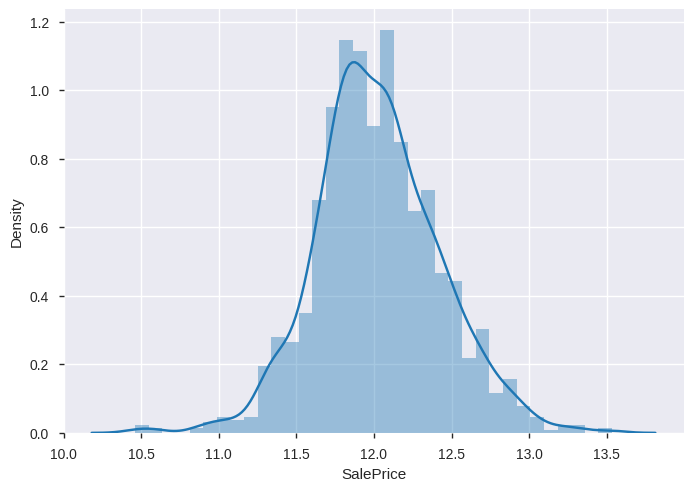

In [ ]:
## Having look at the Variable I want to predict
#Sales Price is skewed but normal distributions are more useful, therefore I will use a log 1+x transformation (to avoid = 0 errors)
df['SalePrice'] = np.log1p(df["SalePrice"])
sns.distplot(df['SalePrice'])

In [ ]:
## Some of the non-numeric predictors are stored as numbers; convert them into strings 
df['MSSubClass'] = df['MSSubClass'].apply(str)
df['MoSold'] = df['MoSold'].astype(str)

## 2. Deadling with Missing values

In [ ]:
## There seem to be columns with a lot of NaN, I want to know how much NaN per column
NAN = [(column, df[column].isna().mean()) for column in df]
NAN = pd.DataFrame(NAN, columns=["column", "NaN_percentage"])
NAN = NAN[NAN.NaN_percentage > 0.5]

## I am deleting all columns that have at least 50% NaN
columns_with_high_NaN_to_drop = []
for index, row in NAN.iterrows():
    columns_with_high_NaN_to_drop.append(row['column'])

df=df.drop(columns = columns_with_high_NaN_to_drop)

In [ ]:
## Manually dealing with missing values
# Choose category that baseline refers to
df['Functional'] = df['Functional'].fillna('Typ') 
df['SaleType'] = df['SaleType'].fillna('Other') 
df['CentralAir'] = df['CentralAir'].fillna('No') 

# Replace the null values with None as I expect that there is no Garage, Basement, Fireplace or Decks and therefore not applicable
for feature in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                'Fireplaces', 'FireplaceQu',
                'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']:
  df[feature] = df[feature].fillna('None')
df['MasVnrArea'] = df['MasVnrArea'].fillna(0) #0 because its numerical
df['MasVnrArea'] = df['MasVnrArea'].astype(int)

In [ ]:
# Replace the the missing values in each of the columns below with their mode as its the most common type
def mode_for_null(column):
  df[column] = df[column].fillna(df[column].mode()[0])

mode_for_null('Electrical')
mode_for_null('KitchenQual')
mode_for_null('SaleType')
mode_for_null('SaleCondition')
mode_for_null('Heating')
mode_for_null('MSSubClass')
mode_for_null('Utilities')
mode_for_null('Street')
mode_for_null('MSZoning')

# Replace the the missing values in each of the columns below with the medium of their group
# LotFrontage: Linear feet of street connected to property, I expect that this is similar for neighbors
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Filling Roofmaterial Nones with most common material for RoofStyle
df['RoofMatl'] = df.groupby('RoofStyle')['RoofMatl'].transform(lambda x: x.fillna(x.mode()[0]))

In [ ]:
# I have no intuition around how to fill in the rest of the categorical features
df = df.fillna('None')

## 3. Normalising Distribution of Features

In [ ]:
# Find first all numerical features
numeric, numeric_colums = find_numeric(df)

In [ ]:
## Test Which numerical features are skews
skew_of_numeric_features = df[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skew_of_numeric_features[skew_of_numeric_features > 0.7]
print("There are {} numerical features with Skew > 0.7 :".format(high_skew.shape[0]))

There are 20 numerical features with Skew > 0.7 :


In [ ]:
## Normalise all those
skew_index = high_skew.index
for i in skew_index:
    df[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1))

## 5. Create New Features

In [ ]:
## No of years Since Remocel at time of Selling & Age of the house at time of selling. Dropping the year remodelling and build but keep yrsold for seasonal influence
df['YearsSinceRemodel'] = df['YrSold'].astype(int) - df['YearRemodAdd'].astype(int)
df['Age_Sold'] = df['YrSold'].astype(int) - df['YearBuilt'].astype(int)

In [ ]:
## Summarizing Features
## Total Size of the House
df['Totalsize'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
## No Of all bathrooms and all Porches
df['No_Bathrooms'] = (df['FullBath'] + df['HalfBath'] + df['BsmtFullBath'] +df['BsmtHalfBath'])
df['No_Porches'] = (df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF'])

# The two kinds Quality & Condition are on the same scale, therefore I endode and summarise
def encode_type(x):
    if x == 'Ex':
        return 5
    if x == 'Gd':
        return 4
    if x == 'TA':
        return 3
    if x == 'Fa':
        return 2
    if x == 'Po':
        return 1
    else:
      return None
df['BsmtCond'] = df['BsmtCond'].transform(encode_type)
df['BsmtQual'] = df['BsmtQual'].transform(encode_type)
df['Total_Basement_Quality'] = df['BsmtCond'] + df['BsmtQual']

df['ExterQual'] = df['ExterQual'].transform(encode_type)
df['ExterCond'] = df['ExterCond'].transform(encode_type)
df['Total_Extern_Quality'] = df['ExterQual'] + df['ExterCond']

df['GarageCond'] = df['GarageCond'].transform(encode_type)
df['GarageQual'] = df['GarageQual'].transform(encode_type)
df['Total_Garage_Cond'] = df['GarageQual'] + df['GarageCond']

df['Total_Home_Quality'] = df['OverallQual'] + df['OverallCond']

In [ ]:
## Creating Dummy Categories for showing that something exists
df['haspool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
df['hasporch'] = df['No_Porches'].apply(lambda x: 1 if x > 0 else 0)

In [ ]:
## Calculating the log and square transformations of some numerical features
# Logarithmic where higher numbers dont have the same added influence 
df['LotFrontage_log'] = np.log(df["LotFrontage"]) #
df['Totalsize_log'] = np.log(df["Totalsize"])

## Squared where Relationship could be u-shaped
df['Age_Sold_sqrt'] = df['Age_Sold']**2 # First older houses probably worse than better

In [ ]:
## Filling the NA that might arived through adding filled with None
df = df.fillna('None')

## 6. Encode Categorical Features

In [ ]:
## Encode all non-numerical and check for corrleation
objects = []
for i in df.columns:
  if df[i].dtype not in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
    objects.append(i)
objects
final_data = pd.get_dummies(df, columns = objects).reset_index(drop=True)

# 7. Model

In [ ]:
##Create Train Test Slit
Y = final_data['SalePrice']
X = final_data.drop(['SalePrice'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=17)

In [ ]:
## Use PCA to reduce Feature Set to the most important 70% and then run a basic Linear Regression 
_sc = StandardScaler()
_pca = PCA(n_components = 0.99)
_model = LinearRegression()

lin_regress_model = Pipeline([
    ('std_scaler', _sc),
    ('pca', _pca),
    ('regressor', _model)
])
lin_regress_model.fit(X_train,y_train)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('pca', PCA(n_components=0.99)),
                ('regressor', LinearRegression())])

In [448]:
## Getting the Final R-squared
logres_model_scores = cross_val_score(lin_regress_model, 
                                      X_test, y_test, cv = 5)
np.mean(logres_model_scores)

0.8046975476493738